
# Investment Strategies — Data Base & Ingestion
**Goal:** Build a clean, reusable data foundation (tickers, prices, dividends, splits) stored in **SQLite**, ready for multi-strategy analysis (Buy & Hold, MA Crossovers, Momentum, Volatility targeting, Risk Parity, Mean Reversion, ETF vs Stocks).  
**Stack:** Python, pandas, yfinance, SQLite (SQLAlchemy), matplotlib.


## Step 0 — Environment

In [59]:

import os
from pathlib import Path
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt

plt.style.use("bmh")

try:
    from sqlalchemy import create_engine, text
    USE_SA = True
except Exception:
    USE_SA = False

# --- Define main project structure ---
PROJECT_DIR = Path(r"C:\Users\Ruben\Desktop\Projects\InvestmentStrategies")
NOTEBOOKS_DIR = PROJECT_DIR / "notebooks"
DATA_DIR = PROJECT_DIR / "data"
RAW_DIR = DATA_DIR / "data_raw"
DB_PATH = DATA_DIR / "market.db"

# --- Create folders if missing ---
for folder in [PROJECT_DIR, NOTEBOOKS_DIR, DATA_DIR, RAW_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

print("✅ Project structure initialized:")
print("Project folder :", PROJECT_DIR.resolve())
print("Notebooks folder:", NOTEBOOKS_DIR.resolve())
print("Data folder :", DATA_DIR.resolve())
print("Raw data folder:", RAW_DIR.resolve())
print("Database path :", DB_PATH.resolve())


✅ Project structure initialized:
Project folder : C:\Users\Ruben\Desktop\Projects\InvestmentStrategies
Notebooks folder: C:\Users\Ruben\Desktop\Projects\InvestmentStrategies\notebooks
Data folder : C:\Users\Ruben\Desktop\Projects\InvestmentStrategies\data
Raw data folder: C:\Users\Ruben\Desktop\Projects\InvestmentStrategies\data\data_raw
Database path : C:\Users\Ruben\Desktop\Projects\InvestmentStrategies\data\market.db


## Step 1 — Ticker Universe

In [60]:

ETFS = ["VTI", "SPY", "QQQ", "ARKK"]
STOCKS = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA",]
DIVERSIFIERS = [
    "AGG",   # US Aggregate Bonds
    "TLT",   #Long-term Treasuries
    "IEF",   # 7-10y Treasuries
    "BIL",   #Short-term Treasuries / cash proxy
    "GLD",   # Gold
    "DBC",   # Broad commodities
    "VNQ",   # US REITs
    "EFA",   # Developed ex-US equities
    "EEM",   # Emerging markets equities
    "XLE",   #Energy sector ETF
    "XLV",   #Healthcare ETF
]
BENCH = ["^GSPC"]
TICKERS = ETFS + STOCKS + BENCH + DIVERSIFIERS

START = "2015-01-01"
END   = "2025-01-01"

print("Tickers:", TICKERS)


Tickers: ['VTI', 'SPY', 'QQQ', 'ARKK', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', '^GSPC', 'AGG', 'TLT', 'IEF', 'BIL', 'GLD', 'DBC', 'VNQ', 'EFA', 'EEM', 'XLE', 'XLV']


## Step 2 — Ingestion (with caching & fallback)

In [61]:

def load_from_csv_or_none(symbol: str) -> pd.DataFrame | None:
    path = RAW_DIR / f"{symbol}.csv"
    if path.exists():
        df = pd.read_csv(path)
        return df
    return None


def save_to_csv(symbol: str, df: pd.DataFrame) -> None:
    path = RAW_DIR / f"{symbol}.csv"
    df.to_csv(path, index=False)

def fetch_yf(symbol: str, start: str, end: str) -> pd.DataFrame:
    import yfinance as yf
    df = yf.download(symbol, start=start, end=end)
    df = df.reset_index()
    return df

def get_symbol_history(symbol: str, start: str, end: str) -> pd.DataFrame:
    cached = load_from_csv_or_none(symbol)
    if cached is not None:
        return cached
    try:
        df = fetch_yf(symbol, start, end)
        if not df.empty:
            save_to_csv(symbol, df)
            return df
    except Exception as e:
        print(f"[WARN] yfinance failed for {symbol}: {e}")
    raise RuntimeError(f"Could not load data for {symbol}. Provide CSV at {RAW_DIR / (symbol + '.csv')}")


## Step 3 — Normalize & Validate

In [62]:

def clean_price_frame(symbol: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Robust normalization to a standard schema:
    ['Date','Open','High','Low','Close','Adj Close','Volume','Symbol'].
    Handles MultiIndex columns, case/alias differences, and date in index.
    """
    df = df.copy()

    # 0) Flatten/normalize column names safely
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join([str(x) for x in col if x is not None]) for col in df.columns]
    df.columns = pd.Index(map(str, df.columns)).str.strip().str.lower()

    # 1) Ensure we have a 'date' column
    if "date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "date"})
        elif "datetime" in df.columns:
            df.rename(columns={"datetime": "date"}, inplace=True)
        else:
            # try to detect first col as date if it looks like dates
            first_col = df.columns[0]
            try:
                pd.to_datetime(df[first_col])
                df.rename(columns={first_col: "date"}, inplace=True)
            except Exception:
                raise ValueError(f"{symbol}: no recognizable date column")

    # 2) Parse dates
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # 3) Unify adjusted close naming
    if "adj_close" in df.columns and "adj close" not in df.columns:
        df.rename(columns={"adj_close": "adj close"}, inplace=True)

    # 4) Keep only standard columns if present
    keep_lc = [c for c in ["date","open","high","low","close","adj close","volume"] if c in df.columns]
    df = df[keep_lc].copy()

    # 5) Sort and clean
    df = df.sort_values("date").dropna(subset=["date"]).reset_index(drop=True)

    # 6) Title-Case back + Symbol
    rename_back = {
        "date": "Date",
        "open": "Open",
        "high": "High",
        "low": "Low",
        "close": "Close",
        "adj close": "Adj Close",
        "volume": "Volume",
    }
    df.rename(columns=rename_back, inplace=True)
    df["Symbol"] = symbol
    return df

frames = []
for sym in TICKERS:
    raw = get_symbol_history(sym, START, END)
    frames.append(clean_price_frame(sym, raw))

prices_all = pd.concat(frames, ignore_index=True)
print(prices_all.head(), "\n", prices_all.tail(), "\n", prices_all.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57868 entries, 0 to 57867
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    57868 non-null  datetime64[ns]
 1   Open    57868 non-null  object        
 2   High    57868 non-null  object        
 3   Low     57868 non-null  object        
 4   Close   57868 non-null  object        
 5   Volume  57868 non-null  object        
 6   Symbol  57868 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 3.1+ MB
        Date               Open               High                Low  \
0 2015-01-02  88.81782991291179  89.00966388272424  87.80028964539694   
1 2015-01-05  87.86699281547848   88.0338063042379  86.62426254981952   
2 2015-01-06  87.07466044789189  87.15806402118822  85.49830936843748   
3 2015-01-07  86.81611157012888  87.11636956084051  86.36573094734696   
4 2015-01-08  87.75024073638716  88.60930966166029  87.66683716017049   

## Step 4 — Database schema creation and data loading

In [63]:

# Define the SQL schema (DDL)
ASSETS_DDL = '''
CREATE TABLE IF NOT EXISTS assets (
    symbol TEXT PRIMARY KEY,
    type   TEXT CHECK (type IN ('ETF','STOCK','INDEX'))
);
'''

PRICES_DDL = '''
CREATE TABLE IF NOT EXISTS prices (
    symbol    TEXT NOT NULL,
    date      TEXT NOT NULL,
    open      REAL,
    high      REAL,
    low       REAL,
    close     REAL,
    adj_close REAL,
    volume    REAL,
    PRIMARY KEY (symbol, date),
    FOREIGN KEY (symbol) REFERENCES assets(symbol)
);
'''

INDEXES_DDL = [
    "CREATE INDEX IF NOT EXISTS idx_prices_date ON prices(date);"
    # The (symbol, date) primary key already provides a unique index,
    # so we only add a date index to speed up time-based lookups.
]


def ensure_db_schema(db_path: Path):
    """
    Ensures that the SQLite database exists and has the required schema.
    Returns either:
      - SQLAlchemy Engine (if available), or
      - sqlite3.Connection (as a fallback).
    """
    try:
        from sqlalchemy import create_engine
        eng = create_engine(f"sqlite:///{db_path}")
        with eng.begin() as con:
            con.exec_driver_sql(ASSETS_DDL)
            con.exec_driver_sql(PRICES_DDL)
            for ddl in INDEXES_DDL:
                con.exec_driver_sql(ddl)
        return eng  # Return Engine
    except Exception:
        # Fallback to sqlite3 if SQLAlchemy is unavailable
        con = sqlite3.connect(db_path)
        con.execute("PRAGMA foreign_keys = ON;")
        cur = con.cursor()
        cur.execute(ASSETS_DDL)
        cur.execute(PRICES_DDL)
        for ddl in INDEXES_DDL:
            cur.execute(ddl)
        con.commit()
        return con  # Return sqlite3.Connection


## Step 5 — Load cleaned data into the database

In [64]:

def load_into_db(engine_or_con, assets_df: pd.DataFrame, prices_all: pd.DataFrame):
    """
    Write assets and prices into SQLite without dropping schema:
    - normalize column names to snake_case for SQL
    - enforce numeric types and ISO dates
    - DELETE rows then append (keeps PK/FK/indexes intact)
    """
    # Prepare prices (SQL-friendly)
    p = prices_all.copy()
    p.columns = [c.strip().lower().replace(" ", "_") for c in p.columns]

    # Enforce numeric columns
    for c in ["open", "high", "low", "close", "adj_close", "volume"]:
        if c in p.columns:
            p[c] = pd.to_numeric(p[c], errors="coerce")

    # Ensure ISO date strings
    if "date" in p.columns and not np.issubdtype(p["date"].dtype, np.datetime64):
        p["date"] = pd.to_datetime(p["date"], errors="coerce")
    if "date" in p.columns and np.issubdtype(p["date"].dtype, np.datetime64):
        p["date"] = p["date"].dt.strftime("%Y-%m-%d")

    # Prepare assets (SQL-friendly)
    a = assets_df.copy()
    a.columns = [c.strip().lower() for c in a.columns]

    # SQLAlchemy path
    try:
        from sqlalchemy.engine import Engine
        if isinstance(engine_or_con, Engine):
            eng = engine_or_con
            with eng.begin() as con:
                con.exec_driver_sql("DELETE FROM assets;")
                a.to_sql("assets", con, if_exists="append", index=False)

                con.exec_driver_sql("DELETE FROM prices;")
                p.to_sql("prices", con, if_exists="append", index=False)
            print("Data successfully loaded using SQLAlchemy Engine.")
            return
    except Exception:
        pass

    # sqlite3 path
    con = engine_or_con
    with con:  # transaction
        cur = con.cursor()
        cur.execute("DELETE FROM assets;")
        a.to_sql("assets", con, if_exists="append", index=False)

        cur.execute("DELETE FROM prices;")
        p.to_sql("prices", con, if_exists="append", index=False)
    print("Data successfully loaded into SQLite using sqlite3.")

# --- Execute Step 5: create connection, build assets_df, load ---

DB_PATH = Path(r"C:\Users\Ruben\Desktop\Projects\InvestmentStrategies\market.db")
engine_or_con = ensure_db_schema(DB_PATH)

# Build assets_df from your lists (ETFS, STOCKS, BENCH already defined above)
assets_rows = []
for s in ETFS:
    assets_rows.append((s, "ETF"))
for s in STOCKS:
    assets_rows.append((s, "STOCK"))
for s in BENCH:
    assets_rows.append((s, "INDEX"))
assets_df = pd.DataFrame(assets_rows, columns=["symbol", "type"])

# prices_all comes from Step 3 (the cleaned, combined DataFrame for all tickers)
load_into_db(engine_or_con, assets_df, prices_all)


Data successfully loaded using SQLAlchemy Engine.


## Step 6 — Example SQL Queries

   symbol  rows       start         end
0    AAPL  2516  2015-01-02  2024-12-31
1     AGG  2516  2015-01-02  2024-12-31
2    AMZN  2516  2015-01-02  2024-12-31
3    ARKK  2516  2015-01-02  2024-12-31
4     BIL  2516  2015-01-02  2024-12-31
5     DBC  2516  2015-01-02  2024-12-31
6     EEM  2516  2015-01-02  2024-12-31
7     EFA  2516  2015-01-02  2024-12-31
8     GLD  2516  2015-01-02  2024-12-31
9   GOOGL  2516  2015-01-02  2024-12-31
10    IEF  2516  2015-01-02  2024-12-31
11   META  2516  2015-01-02  2024-12-31
12   MSFT  2516  2015-01-02  2024-12-31
13   NVDA  2516  2015-01-02  2024-12-31
14    QQQ  2516  2015-01-02  2024-12-31
15    SPY  2516  2015-01-02  2024-12-31
16    TLT  2516  2015-01-02  2024-12-31
17   TSLA  2516  2015-01-02  2024-12-31
18    VNQ  2516  2015-01-02  2024-12-31
19    VTI  2516  2015-01-02  2024-12-31 

   symbol        date        close
0    AAPL  2024-12-31   249.534180
1     AGG  2024-12-31    94.099380
2    AMZN  2024-12-31   219.389999
3    ARKK  2024-12

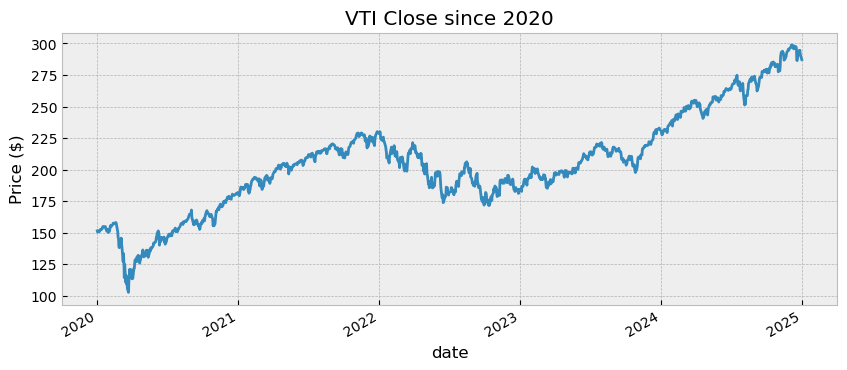

In [65]:

SQL_TOP10 = '''
SELECT symbol, COUNT(*) AS rows, MIN(date) AS start, MAX(date) AS end
FROM prices
GROUP BY symbol
ORDER BY symbol;
'''
SQL_LAST_CLOSES = '''
SELECT p.symbol, p.date, p.close
FROM prices p
JOIN (
    SELECT symbol, MAX(date) AS mdate FROM prices GROUP BY symbol
) t ON p.symbol = t.symbol AND p.date = t.mdate
ORDER BY p.symbol;
'''
SQL_VTI_SINCE_2020 = '''
SELECT date, close FROM prices
WHERE symbol = 'VTI' AND date >= '2020-01-01'
ORDER BY date;
'''

def run_sql(query: str) -> pd.DataFrame:
    if USE_SA:
        eng = create_engine(f"sqlite:///{DB_PATH}")
        with eng.connect() as con:
            return pd.read_sql_query(query, con)
    else:
        with sqlite3.connect(DB_PATH) as con:
            return pd.read_sql_query(query, con)

print(run_sql(SQL_TOP10).head(20), "\n")
print(run_sql(SQL_LAST_CLOSES), "\n")

vti = run_sql(SQL_VTI_SINCE_2020)

vti["date"]  = pd.to_datetime(vti["date"], errors="coerce")
vti["close"] = pd.to_numeric(vti["close"], errors="coerce")

ax = vti.set_index("date")["close"].plot(figsize=(10, 4), title="VTI Close since 2020")
ax.set_ylabel("Price ($)")
plt.show()


## Step 7 — Data Quality Checks

Duplicate rows: 0


,symbol,date,cnt


,symbol,na_close,na_volume
0,AAPL,0,0
1,AGG,0,0
2,AMZN,0,0
3,ARKK,0,0
4,BIL,0,0
5,DBC,0,0
6,EEM,0,0
7,EFA,0,0
8,GLD,0,0
9,GOOGL,0,0


,symbol,start,end,rows
0,AAPL,2015-01-02,2024-12-31,2516
1,AGG,2015-01-02,2024-12-31,2516
2,AMZN,2015-01-02,2024-12-31,2516
3,ARKK,2015-01-02,2024-12-31,2516
4,BIL,2015-01-02,2024-12-31,2516
5,DBC,2015-01-02,2024-12-31,2516
6,EEM,2015-01-02,2024-12-31,2516
7,EFA,2015-01-02,2024-12-31,2516
8,GLD,2015-01-02,2024-12-31,2516
9,GOOGL,2015-01-02,2024-12-31,2516


Invalid rows: 0


,symbol,date,open,high,low,close,volume


,symbol,start,end,rows,days_span,rows_to_span_ratio
0,AAPL,2015-01-02,2024-12-31,2516,3652,0.688938
1,AGG,2015-01-02,2024-12-31,2516,3652,0.688938
2,AMZN,2015-01-02,2024-12-31,2516,3652,0.688938
3,ARKK,2015-01-02,2024-12-31,2516,3652,0.688938
4,BIL,2015-01-02,2024-12-31,2516,3652,0.688938
5,DBC,2015-01-02,2024-12-31,2516,3652,0.688938
6,EEM,2015-01-02,2024-12-31,2516,3652,0.688938
7,EFA,2015-01-02,2024-12-31,2516,3652,0.688938
8,GLD,2015-01-02,2024-12-31,2516,3652,0.688938
9,GOOGL,2015-01-02,2024-12-31,2516,3652,0.688938


High/Low envelope violations: 13


,symbol,date,open,high,low,close,viol
12595,DBC,2015-01-26,15.100848,15.205714,15.057153,15.057153,True
13530,DBC,2018-10-10,16.018432,16.027171,15.747526,15.747526,True
18456,EFA,2018-05-10,57.018491,57.210316,56.914591,57.210316,True
41438,TLT,2019-09-13,117.009633,117.373497,115.537277,115.537277,True
41972,TLT,2021-10-26,126.511026,126.930931,125.741226,126.930931,True
45488,VNQ,2015-10-19,53.507565,54.276924,53.433973,54.276924,True
45531,VNQ,2015-12-18,53.467416,53.554391,52.905449,52.905449,True
45592,VNQ,2016-03-18,56.669871,56.812326,56.317123,56.317123,True
45664,VNQ,2016-06-30,60.899193,61.369831,60.400869,61.369831,True
45944,VNQ,2017-08-10,60.078398,60.186935,59.774498,59.774498,True


Large daily moves (>40%): 0


,symbol,date,close,ret


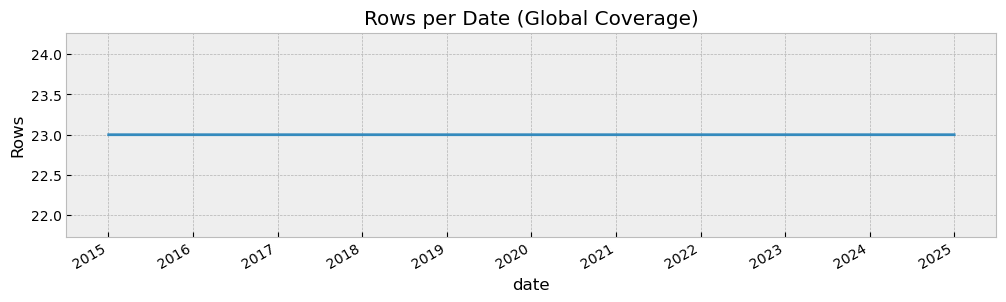

,symbol,na_open,na_high,na_low,na_close,na_volume
0,AAPL,0,0,0,0,0
1,AGG,0,0,0,0,0
2,AMZN,0,0,0,0,0
3,ARKK,0,0,0,0,0
4,BIL,0,0,0,0,0
5,DBC,0,0,0,0,0
6,EEM,0,0,0,0,0
7,EFA,0,0,0,0,0
8,GLD,0,0,0,0,0
9,GOOGL,0,0,0,0,0


Data Quality Summary: {'duplicate_rows': 0, 'invalid_rows': 0, 'hl_envelope_violations': 13, 'large_moves_gt40pct': 0, 'symbols': ['AAPL', 'AGG', 'AMZN', 'ARKK', 'BIL', 'DBC', 'EEM', 'EFA', 'GLD', 'GOOGL', 'IEF', 'META', 'MSFT', 'NVDA', 'QQQ', 'SPY', 'TLT', 'TSLA', 'VNQ', 'VTI', 'XLE', 'XLV', '^GSPC']}


In [66]:

try:
    from IPython.display import display
except Exception:
    display = print

# 7.1 Check for duplicate (symbol, date) rows
dups = run_sql("""
SELECT symbol, date, COUNT(*) AS cnt
FROM prices
GROUP BY symbol, date
HAVING cnt > 1
""")
print("Duplicate rows:", len(dups))
display(dups.head(10))
# What to do if this flag fires:
#   → Drop duplicate rows (e.g. df.drop_duplicates(['symbol','date']))
#   → Verify data ingestion process (may have appended data twice)
#   → 'symbol' + 'date' should be a unique index


# 7.2 Check for missing Close or Volume values
na_stats = run_sql("""
SELECT symbol,
       SUM(CASE WHEN close  IS NULL THEN 1 ELSE 0 END) AS na_close,
       SUM(CASE WHEN volume IS NULL THEN 1 ELSE 0 END) AS na_volume
FROM prices
GROUP BY symbol
ORDER BY symbol
""")
display(na_stats.head(20))
# What to do if this flag fires:
#   → Forward fill isolated NaNs in Close (ffill) if minor
#   → Drop days where Volume is missing frequently
#   → If too many missing values — reload data


# 7.3 Data coverage per symbol
coverage = run_sql("""
SELECT symbol, MIN(date) AS start, MAX(date) AS end, COUNT(*) AS rows
FROM prices GROUP BY symbol
ORDER BY symbol
""")
display(coverage)
# What to do if this flag fires:
#   → If coverage period is too short, check if ticker is delisted/new
#   → Ensure correct START/END dates in data download
#   → Drop incomplete symbols for fair comparison


# 7.4 Invalid or impossible numerical values
invalid = run_sql("""
SELECT symbol, date, open, high, low, close, volume
FROM prices
WHERE close <= 0 OR open <= 0 OR high <= 0 OR low <= 0 OR volume < 0
ORDER BY symbol, date
""")
print("Invalid rows:", len(invalid))
display(invalid.head(10))
# What to do if this flag fires:
#   → Delete rows with zero/negative prices or negative volume
#   → Frequent errors = data source issue (e.g. Yahoo glitch)


# 7.5 Gaps and density ratio
gaps = run_sql("""
SELECT symbol,
       MIN(date) AS start,
       MAX(date) AS end,
       COUNT(*)  AS rows,
       CAST(julianday(MAX(date)) - julianday(MIN(date)) + 1 AS INT) AS days_span
FROM prices
GROUP BY symbol
ORDER BY symbol
""")
gaps["rows_to_span_ratio"] = gaps["rows"] / gaps["days_span"]
display(gaps)
# What to do if this flag fires:
#   → rows_to_span_ratio << 0.25 → many missing trading days
#   → Check download or API connection for interruptions


# 7.6 OHLC logical consistency
ohlc = run_sql("""
SELECT symbol, date, open, high, low, close
FROM prices
ORDER BY symbol, date
""").copy()

ohlc["viol"] = ~(
    (ohlc["high"] >= ohlc[["open","close"]].max(axis=1)) &
    (ohlc["low"]  <= ohlc[["open","close"]].min(axis=1))
)
viol = ohlc[ohlc["viol"]]
print("High/Low envelope violations:", len(viol))
display(viol.head(10))
# What to do if this flag fires:
#   → 'high' should be >= max(open, close)
#   → 'low'  should be <= min(open, close)
#   → Otherwise data corruption — check those rows manually


# 7.7 Large daily price moves (>40%)
daily = run_sql("""
SELECT symbol, date, close
FROM prices
ORDER BY symbol, date
""").copy()

daily["date"] = pd.to_datetime(daily["date"], errors="coerce")
daily = daily.sort_values(["symbol", "date"])
daily["ret"] = daily.groupby("symbol")["close"].pct_change()

outliers = daily[daily["ret"].abs() > 0.40]
print("Large daily moves (>40%):", len(outliers))
display(outliers.head(20))
# What to do if this flag fires:
#   → Could be stock splits or extreme events
#   → Verify using corporate actions data
#   → Adjust for splits (use 'Adj Close' when available)


# 7.8 Global daily coverage (rows per date)
day_cov = run_sql("""
SELECT date, COUNT(*) AS rows
FROM prices
GROUP BY date
ORDER BY date
""")
ax = day_cov.set_index(pd.to_datetime(day_cov["date"]))["rows"] \
            .plot(figsize=(12,3), title="Rows per Date (Global Coverage)")
ax.set_ylabel("Rows")
plt.show()
# What to do if this flag fires:
#   → Sudden dips = missing data for entire market day
#   → Check for holidays or failed data pulls


# 7.9 Full NA summary (OHLCV)
na_full = run_sql("""
SELECT symbol,
       SUM(CASE WHEN open   IS NULL THEN 1 ELSE 0 END) AS na_open,
       SUM(CASE WHEN high   IS NULL THEN 1 ELSE 0 END) AS na_high,
       SUM(CASE WHEN low    IS NULL THEN 1 ELSE 0 END) AS na_low,
       SUM(CASE WHEN close  IS NULL THEN 1 ELSE 0 END) AS na_close,
       SUM(CASE WHEN volume IS NULL THEN 1 ELSE 0 END) AS na_volume
FROM prices
GROUP BY symbol
ORDER BY symbol
""")
display(na_full)
# What to do if this flag fires:
#   → Quick summary of missing values per column
#   → Helps decide if refetching data is required


# 7.10 Final summary dictionary
summary = {
    "duplicate_rows": int(len(dups)),
    "invalid_rows": int(len(invalid)),
    "hl_envelope_violations": int(len(viol)),
    "large_moves_gt40pct": int(len(outliers)),
    "symbols": list(coverage["symbol"]),
}
print("Data Quality Summary:", summary)
# What to do if this flag fires:
#   → Review all non-zero flags
#   → If several issues persist — rebuild or reload dataset



## Next Steps
- Strategy notebooks will reuse this SQLite DB (`project_data/market.db`):
  - Buy & Hold (long-term) — focus on **VTI** and compare to QQQ/ARKK and selected stocks.
  - Momentum / Mean Reversion — applied to both ETFs and stocks.
  - Moving Averages (SMA/EMA) — multiple windows + transaction costs.
  - Risk Parity — multi-asset allocation (consider adding bond ETFs like TLT/IEF).
- Each strategy notebook will include **English explanations** (what, why, pros/cons) followed by charts and metrics.
